# Исследование объявлений о продаже квартир

**Задача**

Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры, чтобы построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План работы:**
1. Открыть файл и изучить общую информацию о данных.
2. Предобработка данных:
 * выявить пропуски и заменить их там, где это возможно;
 * изучить типы данных и при необходимости их изменить;
 * исследовать категориальные переменные на предмет явных и скрытых дубликатов;
 * исследовать данные на предмет аномалий и выбросов, при необходимости от них избавиться.
3. Изучить зависимость цены на квартиру от различных параметров.
4. Написать общий вывод.

### Открыть файл с данными и изучить общую информацию. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

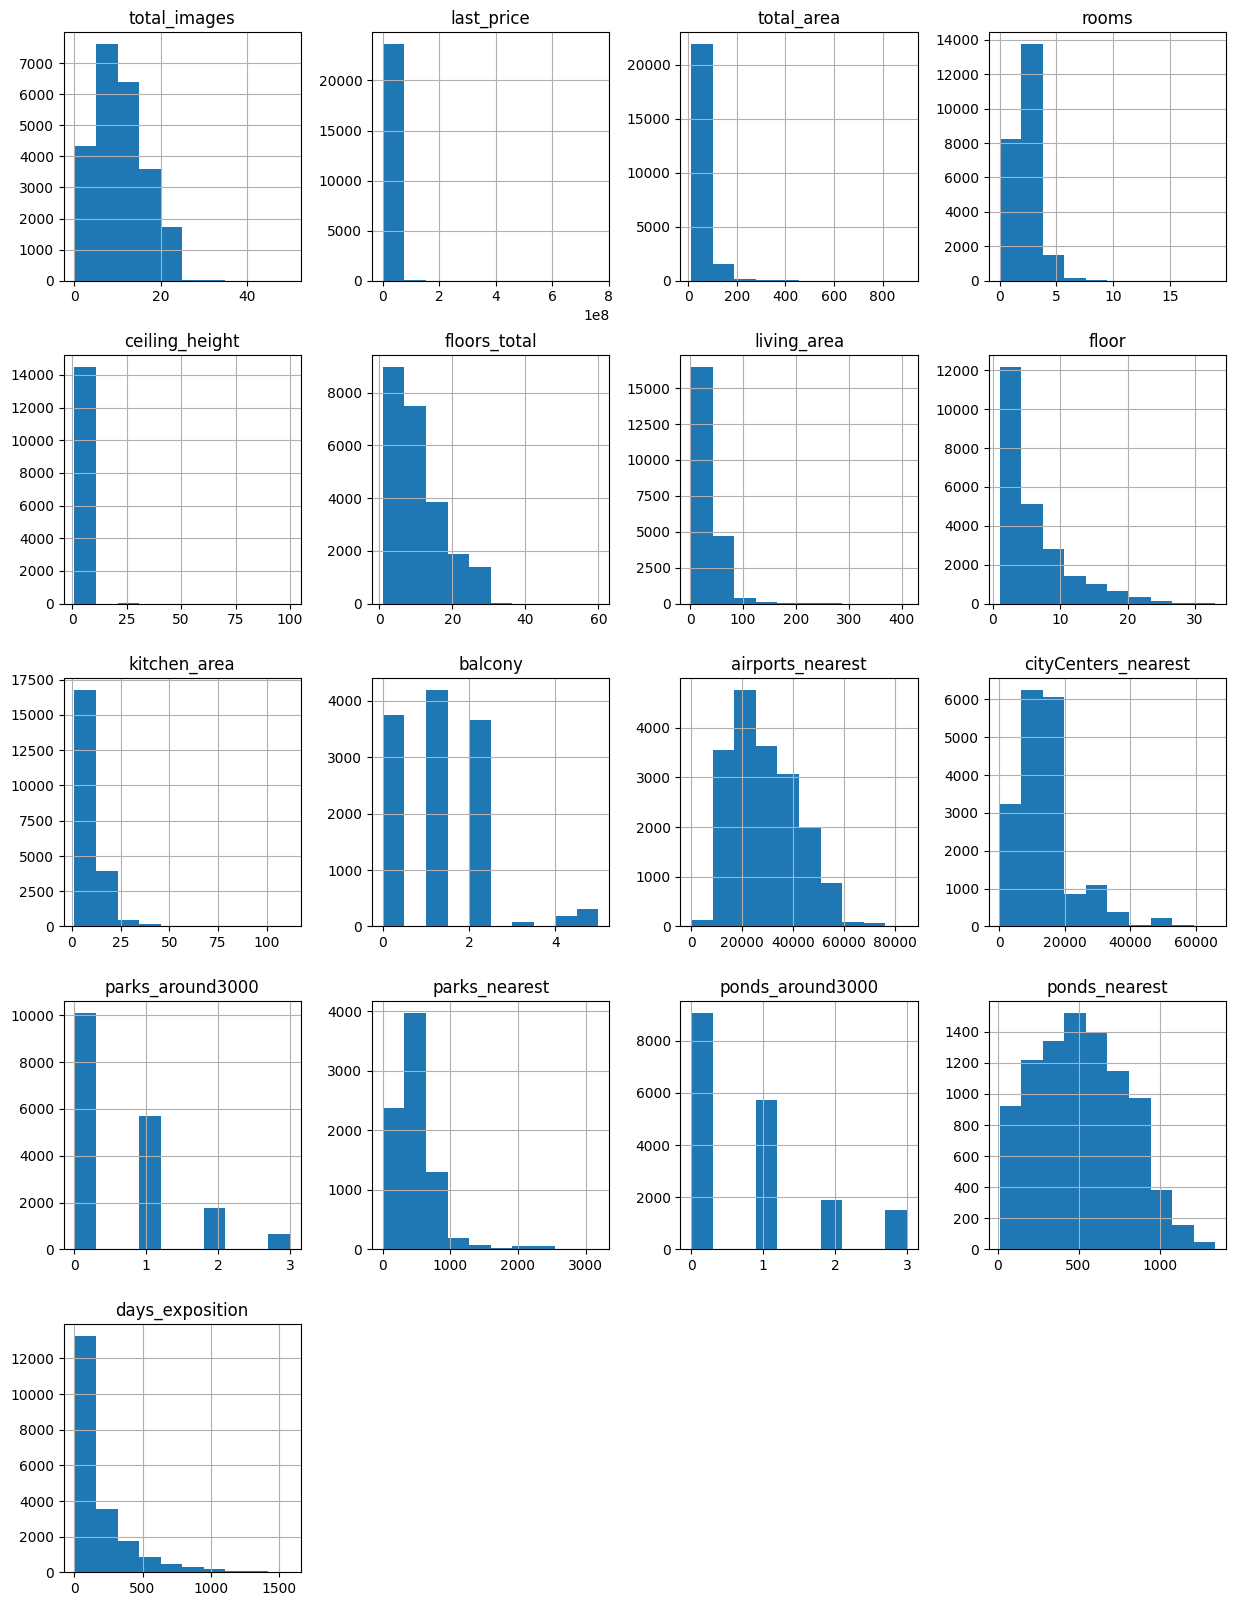

In [2]:
#импортируем пандас, читаем файл, изучаем о нем информацию и строим гистограммы для всех числовых столбцов
try:
    df = pd.read_csv(r"C:\Users\Markm\Downloads\real_estate_data.csv", sep = '\t')
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
df.info()
df.hist(figsize = (15,20));



### Предобработка данных

**Изучение пропусков**

In [3]:
#для изучения пропусков
for column_name in df.columns:
    if df[column_name].isnull().sum() > 0:#с помощью цикла проверяем, есть ли пропущенные значения в столбце
        if df[column_name].dtype == 'object' or df[column_name].dtype == 'bool': #если в столбце есть пропущенные значения и он имеет тип данных 'object' или 'bool'
            print(column_name, df[column_name].unique())#выводим имя столбца и уникальные значения
        else:
            print(column_name, "Медиана:", df[column_name].median(),"Среднее:", df[column_name].mean())#если тип данных другой (количественные переменные), то выводим среднее и медиану, чтобы посмотреть, чем можно заменить пропуски
    else:
        print('В стоблце', column_name, 'нет пропущенных значений')#если пропусков нет, пишем что для этого столбца нет пропусков
        

В стоблце total_images нет пропущенных значений
В стоблце last_price нет пропущенных значений
В стоблце total_area нет пропущенных значений
В стоблце first_day_exposition нет пропущенных значений
В стоблце rooms нет пропущенных значений
ceiling_height Медиана: 2.65 Среднее: 2.77149889685604
floors_total Медиана: 9.0 Среднее: 10.67382374115953
living_area Медиана: 30.0 Среднее: 34.457852427601395
В стоблце floor нет пропущенных значений
is_apartment [nan False True]
В стоблце studio нет пропущенных значений
В стоблце open_plan нет пропущенных значений
kitchen_area Медиана: 9.1 Среднее: 10.569807198543485
balcony Медиана: 1.0 Среднее: 1.1500821018062397
locality_name ['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девя

1. Видим, что среди количественных переменных с пропущенными значениями медиана и среднее не сильно отличаются, значит в данных нет сильных имеющих значение выбросов.
2. Исключение составляет столбец **'days_exposition'**, где медиана меньше среднего почти в 2 раза, что означает, что есть существенные выбросы.
3. Пропуски в parks_around3000 и ponds_around3000 логичнее заменить на 0, так как скорее всего пропуск значения означает, что в районе 3 км нет парков и водоемов.
4. Пропуски в balcony логичнее заменить на 0, так как скорее всего пропуск означает отсутствие балкона.
5. Пропуски в is_apartment логично заменить на False, так как скорее всего пропуск означает, что квартира не является апартаментами. 
6. В стоблцах **'parks_nearest','ponds_nearest'** мы не можем заменить пропущенные значения, так как пропуски в этих столбцах связаны со значениями столбцов parks_around3000 и ponds_around3000, поэтому неправильно было бы заменять все пропущенные значения на какое-то одно. 
6. Пропуски в остальных количественных переменных имеют неясную природу, возможно технические ошибки при записи данных (если данные получены на основе картографических) или неправильный ввод данных пользователем, необходимо уточнить природу пропусков, однако мы можем заменить пропущенные в них значения медианным.

In [4]:
#создадим список столбцов, где пропуски можно заменить медианным значением и заменим их с помощью цикла
column_names_median = ['ceiling_height','floors_total','airports_nearest','cityCenters_nearest'] 
for column_name in column_names_median:
    df[column_name].fillna(value = df[column_name].median(),inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
fill_areas = ['living_area','kitchen_area']
for elem in fill_areas:
    median_area_ratio = df['total_area'].median()/df[elem].median() #соотношение медианной общей площади к медианной жилой и кухонной
    df[elem].fillna(value = df['total_area']/median_area_ratio, inplace = True)#заменяем пропуски на отношение общей площади к найденному выше соотношению
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [6]:
#список столбцов, где надо заменить пропуски на ноль и заменим с помощью цикла
column_list_null = ['balcony','parks_around3000', 'ponds_around3000']
for column_name in column_list_null:
     df[column_name].fillna(value = 0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [7]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')#здесь переводим столбец в формат datetime
df['year'] = df['first_day_exposition'].dt.year #создаем стоблец 'year'
days_exposition_none = df.query('days_exposition.isnull()') #выбираем из датафрейма данные с пропущенными значениями в days_exposition
days_exposition_none.groupby('year')['days_exposition'].apply(lambda x: np.sum(x.isnull())) #группируем данные по году и считаем количество пропущенных знаечний в каждом из годов

year
2014      18
2015      70
2016      67
2017     271
2018     959
2019    1796
Name: days_exposition, dtype: int64

In [8]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Изменение типов данных**
1. Меняем тип данных, в is_apartment на bool,так как список униклаьных значений там [nan False True].
2. floors_total нужно перевести в int, так как число этажей может быть только целым.
3. balcony нужно перевести в int, так как число балконов может быть только целым.
4. parks_around3000 нужно перевести в int, так как число парков может быть только целым.
5. ponds_around3000 нужно перевести в int, так как число водоемов может быть только целым.

In [9]:
df['is_apartment'] = df['is_apartment'].astype('bool')
type_names = ['floors_total','balcony','parks_around3000','ponds_around3000'] #создаем список с названиями столбцов, которые нужно перевести в тип int
for name in type_names:
    df[name] = df[name].astype('int') #с помощью цикла переводим знаечния столбцов в нужный тип 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Поиск дубликатов**

In [10]:
#ищем повторяющиеся значения
df['locality_name']= df['locality_name'].str.lower() #переводим все значения столбца в нижний регистр
df['locality_name']=df['locality_name'].str.replace('ё','е') # заменяем буквы ё на е
chars_to_remove = ["деревня", "городского", 'городской', 'типа','поселок','село'] #создаем список из повторяющихся частей строк, которые нам нужно убрать
for char in chars_to_remove:
   df['locality_name'] = df['locality_name'].str.replace(char,'')
df.tail(10)
#у нас остается просто уникальное название населенного пункта, без неявных дубликатов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year
23689,13,3550000.0,35.30,2018-02-28,1,2.86,15,16.300000,4,False,...,2,санкт-петербург,17284.0,16081.0,1,353.0,2,652.0,29.0,2018
23690,3,5500000.0,52.00,2018-07-19,2,2.65,5,31.000000,2,False,...,0,санкт-петербург,20151.0,6263.0,1,300.0,0,NaN,15.0,2018
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.300000,7,False,...,1,санкт-петербург,19424.0,4489.0,0,NaN,1,806.0,519.0,2016
23692,2,1350000.0,30.00,2017-07-07,1,2.65,5,17.500000,4,False,...,0,тихвин,26726.0,13098.5,0,NaN,0,NaN,413.0,2017
23693,9,4600000.0,62.40,2016-08-05,3,2.60,9,40.000000,8,False,...,0,петергоф,45602.0,34104.0,1,352.0,1,675.0,239.0,2016
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,0,санкт-петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,2017
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.000000,4,False,...,0,тосно,26726.0,13098.5,0,NaN,0,NaN,45.0,2018
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.700000,1,False,...,0,рождествено,26726.0,13098.5,0,NaN,0,NaN,NaN,2018
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,44.278846,12,False,...,2,санкт-петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,2017
23698,4,1350000.0,32.30,2017-07-21,1,2.50,5,12.300000,1,False,...,0,новый учхоз,26726.0,13098.5,0,NaN,0,NaN,NaN,2017


**Поиск аномалий и выбросов**

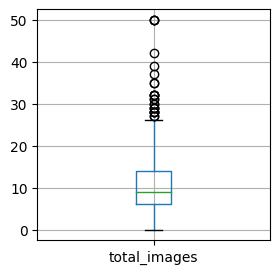

count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64


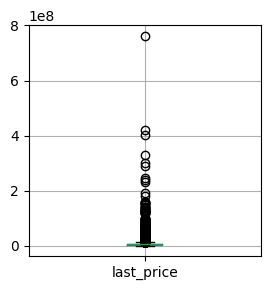

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


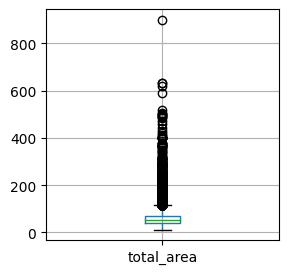

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64
Нельзя построить диаграмму размаха для first_day_exposition


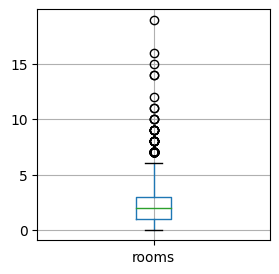

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


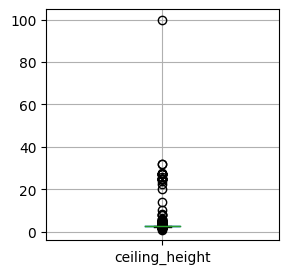

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


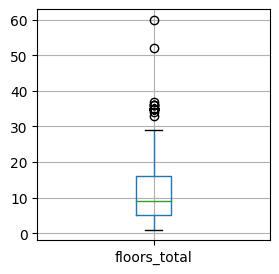

count    23699.000000
mean        10.667750
std          6.585961
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


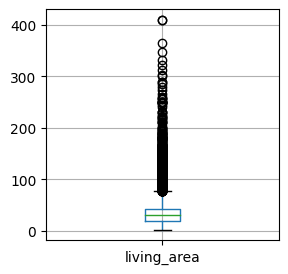

count    23699.000000
mean        34.624296
std         22.381873
min          2.000000
25%         19.000000
50%         30.000000
75%         42.173077
max        409.700000
Name: living_area, dtype: float64


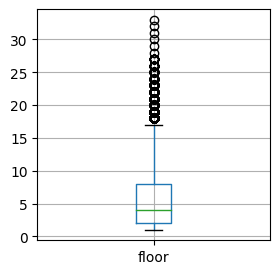

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


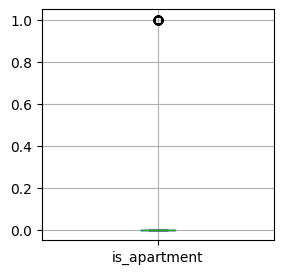

count     23699
unique        2
top       False
freq      23649
Name: is_apartment, dtype: object


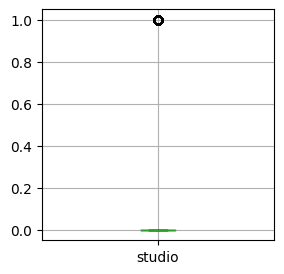

count     23699
unique        2
top       False
freq      23550
Name: studio, dtype: object


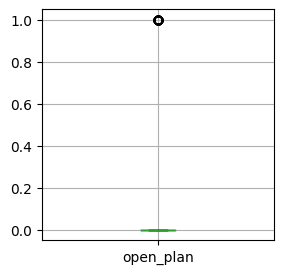

count     23699
unique        2
top       False
freq      23632
Name: open_plan, dtype: object


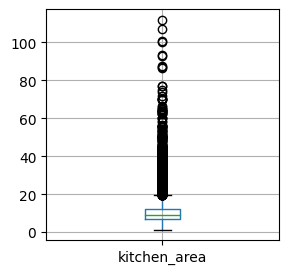

count    23699.000000
mean        10.505495
std          6.039401
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


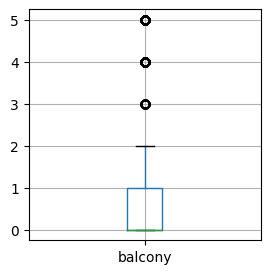

count    23699.000000
mean         0.591080
std          0.959298
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64
Нельзя построить диаграмму размаха для locality_name


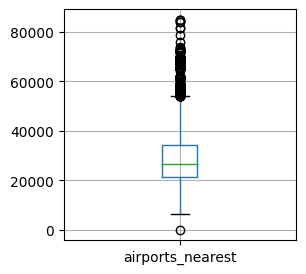

count    23699.000000
mean     28310.148023
std      11090.330161
min          0.000000
25%      21183.000000
50%      26726.000000
75%      34327.000000
max      84869.000000
Name: airports_nearest, dtype: float64


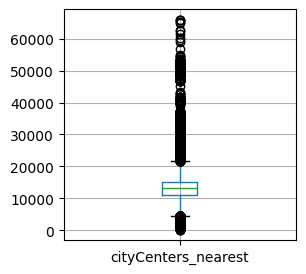

count    23699.000000
mean     13936.792797
std       7553.779633
min        181.000000
25%      10927.000000
50%      13098.500000
75%      15248.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


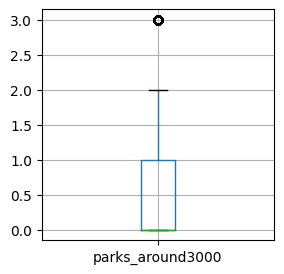

count    23699.000000
mean         0.469049
std          0.748534
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64


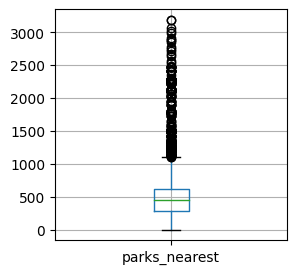

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


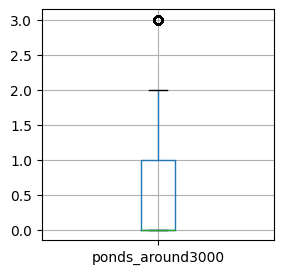

count    23699.000000
mean         0.590911
std          0.883999
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64


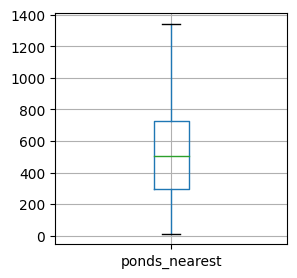

count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64


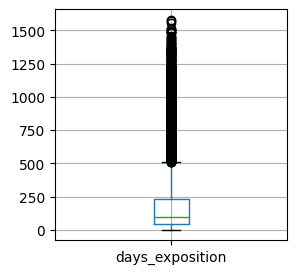

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


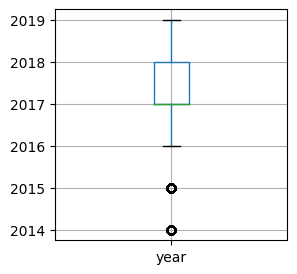

count    23699.000000
mean      2017.367146
std          1.039771
min       2014.000000
25%       2017.000000
50%       2017.000000
75%       2018.000000
max       2019.000000
Name: year, dtype: float64


In [11]:
#чтобы выявить аномалии и выборсы, строим диагрммы размаха для каждого столбца и вызываем метод describe(), чтобы посмотреть распределение данных
for column_name in df.columns:
    try:
        df.boxplot(column= column_name, figsize = (3,3))
        plt.show()
        print(df[column_name].describe())
    except:
        print('Нельзя построить диаграмму размаха для', column_name)

1. total_images - есть отдельные высокие значения (50), но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. 
2. last_price - есть отдельные высокие значения, но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. К тому же, высокая цена может быть важным элементом для последующего анализа.Не удаляем аномалии.
3. **total_area** - есть отдельные высокие значения, но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. К тому же, большая площадь может быть важным элементом для последующего анализа. Однако стоит посмотреть еще раз на значения этого столбца.
4. rooms - есть отдельные высокие значения (19), но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить.
5. **ceiling_height** - высота потолка вряд ли может быть больше 10 м, поэтому все более высокие значения, нужно изменить или удалить. Скорее всего, проищошла ошибка в записи и 20 м на самом деле 2,0 метра.
6. floors_total - есть отдельные высокие значения (60), но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. Значения выглядят правдоподобно.
7. **living_area** - есть отдельные высокие значения, но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. К тому же, большая площадь может быть важным элементом для последующего анализа. Однако стоит посмотреть еще раз на значения этого столбца.
8. floor -есть отдельные высокие значения (>30), но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. Значения выглядят правдоподобно.
9. **kitchen_area** - есть отдельные высокие значения, но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить.К тому же, большая площадь может быть важным элементом для последующего анализа. Однако стоит посмотреть еще раз на значения этого столбца.
10. **balcony** - есть отдельные высокие значения (5), но судя по описательным статистикам, они не влияют на распределение, поэтому их можно оставить. Значения выглядят правдоподобно. Особенно учитывая, что есть квартиры с большой общей плоащью, жилой площадью и площадью кухни, в них вполне может быть 5 балконов. Однако, если таких квартир мало, то в целом для анализа их можно удалить.
11. airports_nearest - нет выбывающихся значений.
12. cityCenters_nearest - нет выбывающихся значений.
13. parks_around3000, parks_nearest,ponds_around3000,ponds_nearest, ponds_nearest - нет выбывающихся значений.
14. days_exposition - есть очень маленькие и очень большие значения, но для этого столбца это логично и объяснимо, какие то квартиры продавались очень долго, а какие-то продались в тот же день.


In [12]:
df = df[df['total_area'] <800]#выбивающееся значение всего 1, поэтому его можно удалить
df = df.query('living_area < 400') #выбивающееся значение всего 1, поэтому его можно удалить
df = df.query('kitchen_area < 80') #выбивающихся знаечний всего 5, поэтому их можно удалить
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23690 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23690 non-null  int64         
 1   last_price            23690 non-null  float64       
 2   total_area            23690 non-null  float64       
 3   first_day_exposition  23690 non-null  datetime64[ns]
 4   rooms                 23690 non-null  int64         
 5   ceiling_height        23690 non-null  float64       
 6   floors_total          23690 non-null  int32         
 7   living_area           23690 non-null  float64       
 8   floor                 23690 non-null  int64         
 9   is_apartment          23690 non-null  bool          
 10  studio                23690 non-null  bool          
 11  open_plan             23690 non-null  bool          
 12  kitchen_area          23690 non-null  float64       
 13  balcony         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23690 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23690 non-null  int64         
 1   last_price            23690 non-null  float64       
 2   total_area            23690 non-null  float64       
 3   first_day_exposition  23690 non-null  datetime64[ns]
 4   rooms                 23690 non-null  int64         
 5   ceiling_height        23690 non-null  float64       
 6   floors_total          23690 non-null  int32         
 7   living_area           23690 non-null  float64       
 8   floor                 23690 non-null  int64         
 9   is_apartment          23690 non-null  bool          
 10  studio                23690 non-null  bool          
 11  open_plan             23690 non-null  bool          
 12  kitchen_area          23690 non-null  float64       
 13  balcony         

<AxesSubplot:>

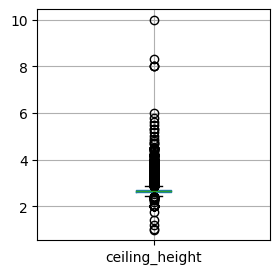

In [13]:
#высоту потолков больше 10 делим на 10, чтобы получить приемлемые для высоты потолка значения, потом строим диаграмму размаха
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] /= 10
df.info()
df.boxplot(column = 'ceiling_height', figsize= (3,3))



count    23680.000000
mean         2.696773
std          0.220988
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23680 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23680 non-null  int64         
 1   last_price            23680 non-null  float64       
 2   total_area            23680 non-null  float64       
 3   first_day_exposition  23680 non-null  datetime64[ns]
 4   rooms                 23680 non-null  int64         
 5   ceiling_height        23680 non-null  float64       
 6   floors_total          23680 non-null  int32         
 7   living_area           23680 non-null  float64       
 8   floor                 23680 non-null  int64         
 9   is_apartment          23680 non-nul

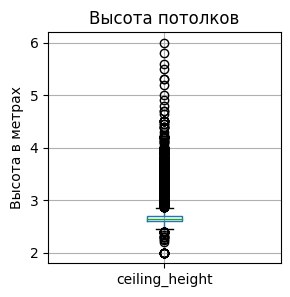

In [14]:
#удаляем выбивающиеся знаечния (>6) и неправдоподобные (<2)
df.loc[df['ceiling_height'] < 2, 'ceiling_height'] 
df = df[(df.ceiling_height >= 2) & (df.ceiling_height <=6)]
print(df['ceiling_height'].describe())
df.info()
df.boxplot(column = 'ceiling_height', figsize= (3,3));
plt.title('Высота потолков')
plt.ylabel('Высота в метрах');

In [15]:
# доля изначального количества данных после предобрабтки
#23699 изначально записей, 23680 после предобработки
data_ratio = (23680/23699)*100
print('Доля изначального количества данных после предобработки:',data_ratio)

Доля изначального количества данных после предобработки: 99.91982784083716


### Посчитаем и добавим в таблицу новые столбцы

In [16]:
#цена одного квадратного метра;
df['m_price'] = df['last_price']/df['total_area']
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
#df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') - пометила решеткой, так как раньше пришлось это написать, чтобы посомтреть зависимость days_exposition от года
df['weekday'] = df['first_day_exposition'].dt.weekday
#месяц публикации объявления;
df['month'] = df['first_day_exposition'].dt.month
#год публикации объявления;
#df['year'] = df['first_day_exposition'].dt.year - тоже уже написано раньше
#тип этажа квартиры (значения — «‎первый», «последний», «другой»);
conditions = [df['floor'] == df['floors_total'], df['floor']== df['floors_total'] - (df['floors_total'] - 1)]
choices = ['последний', 'первый']
df['floor_type'] = np.select (conditions, choices, default='другой')
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).
df['cityCenters_nearest_km'] = df['cityCenters_nearest']/1000
df['cityCenters_nearest_km'] = df['cityCenters_nearest_km'].round()
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,m_price,weekday,month,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,NaN,2019,120370.370370,3,3,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0,NaN,81.0,2018,82920.792079,1,12,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2,574.0,558.0,2015,92785.714286,3,8,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,91.730769,9,False,...,84.0,3,234.0,424.0,2015,408176.100629,4,7,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121.0,2018,100000.000000,1,6,другой,8.0


### Проведите исследовательский анализ данных

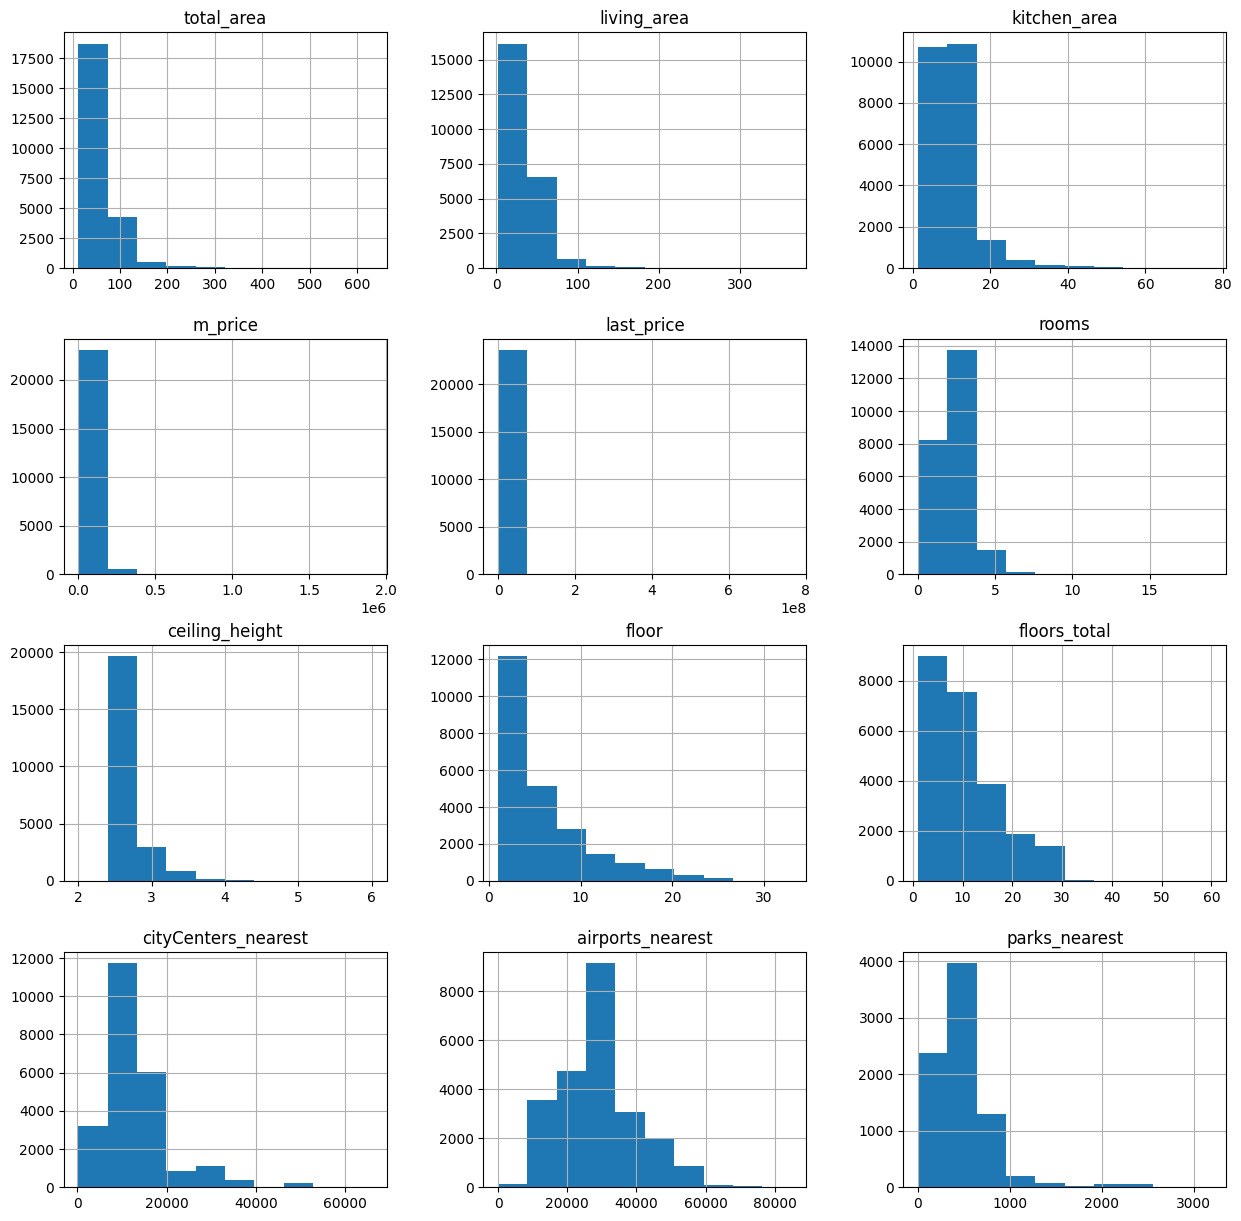

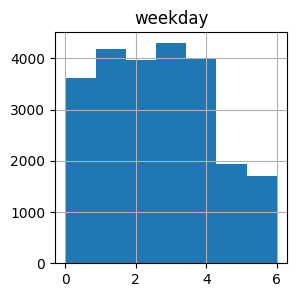

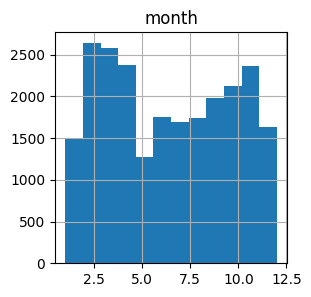

In [17]:
#общая площадь;
#жилая площадь;
#площадь кухни;
#цена объекта;
#количество комнат;
#высота потолков;
#этаж квартиры;
#тип этажа квартиры («первый», «последний», «другой»);
#общее количество этажей в доме;
#расстояние до центра города в метрах;
#расстояние до ближайшего аэропорта;
#расстояние до ближайшего парка;
#день и месяц публикации объявления.
df.hist(['total_area', 'living_area','kitchen_area','m_price','last_price', 'rooms','ceiling_height','floor', 'floor_type','floors_total','cityCenters_nearest','airports_nearest', 'parks_nearest'], bins = 10, figsize = (15,15))
df.hist('weekday', bins = 7, figsize = (3,3));
df.hist('month', bins = 12, figsize = (3,3));

**Выводы по изученным параметрам**
1. Основная масса квартир имеет: общую площадь до 200 квадратных метров; жилую площадь до 110 квадратных метров; площадь кухни до 30 квадратных метров. 
2. Основная масса квартир продается по цене до 200000 за квадратный метр и имеет не больше 6 комнат.
3. Высота потолка в большинстве квартир составляет 2-3,5 метра.
4. Квартиры располагаются в домах, в которых в основном не больше 30 этажей, причем больше всего квартир располагается на первых 10 этажах домов.
5. Расстояние до ближайшего центра города в основном составляет до 20000 метров (20 км), очень редко оно составляет больше 40 км.
6. В основном расстояние до ближайшего аэропорта состаляет от 10 до 60 км, до ближайшего парка - до 1 км.
7. Чаще всего объявления публикуются во вторник и четверг. Меньше всего объявлений публикуются в выходные.
8. Больше всего объявлений публикуется в периоды с февраля по апрель и с сентября по ноябрь. В остальные месяцы наблюдается спад количества публикаций.


Корреляция между total_area и ценой : 0.6402731562181873
Корреляция между living_area и ценой : 0.5785386876331976
Корреляция между kitchen_area и ценой : 0.4984140593058246
Корреляция между rooms и ценой : 0.36010893629973995
Корреляция между weekday и ценой : 0.0019111196080983963
Корреляция между month и ценой : 0.0022842255620299998
Корреляция между year и ценой : -0.043380635602562036


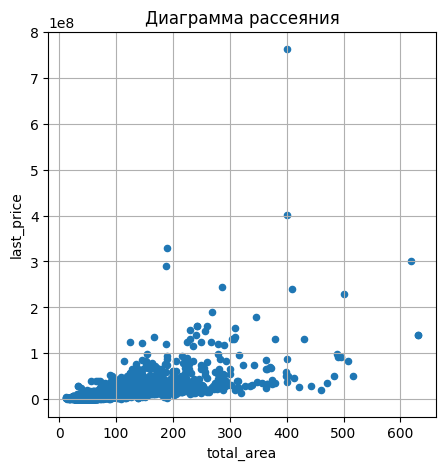

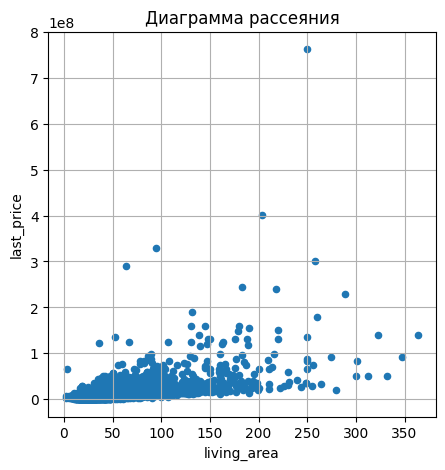

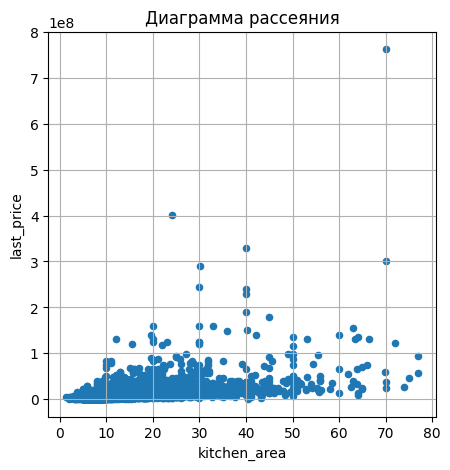

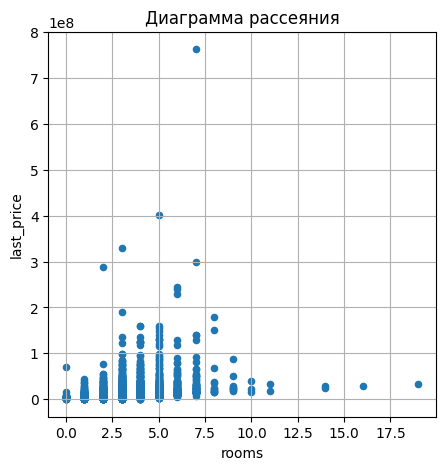

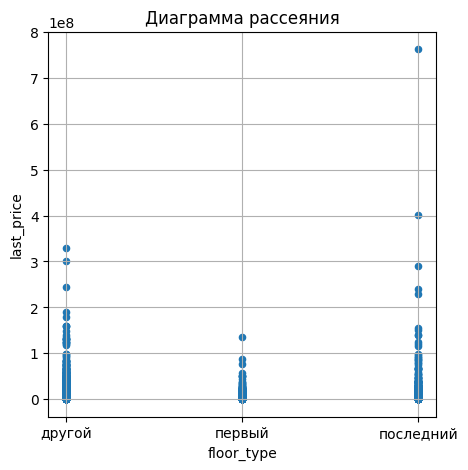

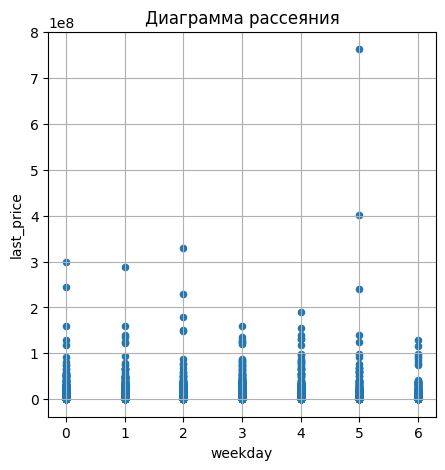

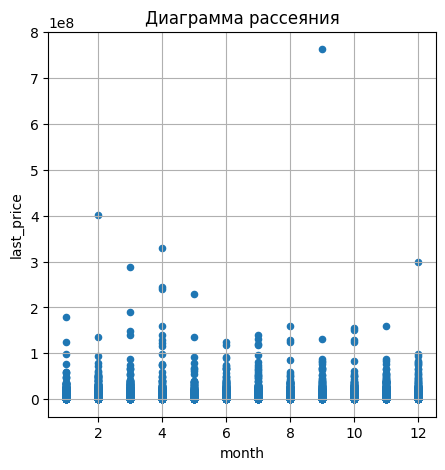

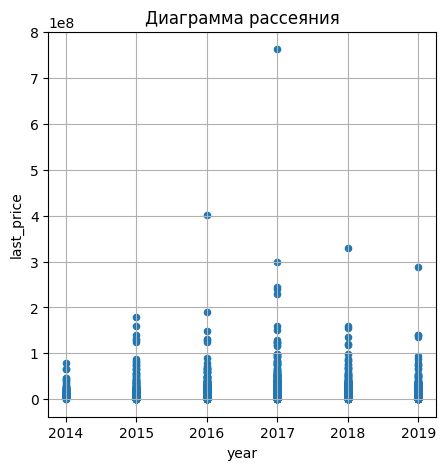

In [18]:
#зависит ли цена от:
#общей площади;
#жилой площади;
#площади кухни;
#количества комнат;
#этажа, на котором расположена квартира (первый, последний, другой);
#даты размещения (день недели, месяц, год).
price_depends= ['total_area','living_area','kitchen_area','rooms','floor_type','weekday','month','year']
for column_name in price_depends:
    try:
        print('Корреляция между', column_name, 'и ценой :', df[column_name].corr(df['last_price']))
        df_pv = df.pivot_table(index = column_name, values = 'last_price', aggfunc = 'mean')
        df_pv.plot(kind = 'scatter',grid = True, figsize = (5,5))
        plt.title('Диаграмма рассеяния')
    except:
        df.plot(kind = 'scatter',grid = True, x=column_name, y='last_price', figsize = (5,5))
        plt.title('Диаграмма рассеяния')
    

**Выводы по зависимости цены от различных параметров**
1. Наибольшая положительная связь есть между ценой и total_area: 0.64, living_area: 0.53. 
2. Более слабая свзяь между ценой kitchen_area: 0.42, rooms: 0,35.  
3. По мере увеличения общей площади, жилой площади, площади кухни и количества комнат цена квадратного метра тоже увеличивается. 
2. С остальными параметрами нет четкой взаимосвязи. 
3. В 2014 году цены за квадратный метр были самыми низкими. В 2015 году цены выросли, однако дальше существенного роста цен не наблюдалось.
4. Цены за квадратный метр в квартирах, расположенных на первом этаже в целом ниже, чем в квартирах, расположенных на других этажах. 

count    20500.000000
mean       180.900244
std        219.767435
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


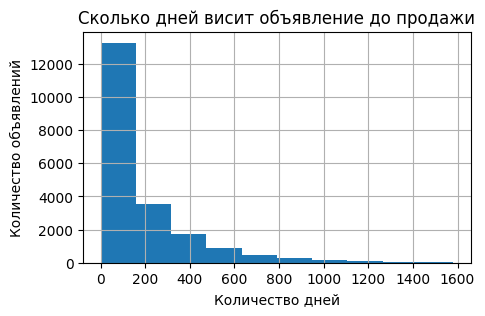

In [19]:
df['days_exposition'].hist(bins = 10, figsize = (5,3))
plt.title('Сколько дней висит объявление до продажи')
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
print((df['days_exposition'].describe()))

**Выводы по days_exposition:**
1. Большинство квартир продаются в промежуток от 0 до 180 дней с момента публикации объявления.
2. Срок продажи свыше 1,5 межквартильного размаха (1,5 *(255 -41) + з квартиль (255) = 576 дней можно считать необычно долгим.
2. 1,5 межквартильного размаха (321) меньше левого уса (1 квартиль = 41), значит он заканчивается 0. Таким образом, необычно быстрых продаж нет. Судя по гистограмме, квартиры обычно продаются быстро. 

In [20]:
popular_locality_names = df['locality_name'].value_counts().head(10).index.tolist()
df.query('locality_name == @popular_locality_names').pivot_table(index = 'locality_name', values = 'm_price')

,m_price
locality_name,
кудрово,92473.547576
мурино,85681.762601
парголово,90175.913458
шушары,78677.364217
всеволожск,68654.473986
выборг,58141.909153
гатчина,68746.146763
колпино,75424.579098
пушкин,103125.819291


**Выводы по ценам на квартиры в 10 самых распространненых населенных пунктах**
1. Населенные пункты, с наибольшим числом объявлений по убыванию количества объявлений: 
* санкт-петербург    
* мурино              
* шушары              
* всеволожск          
* пушкин               
* колпино              
* парголово         
* гатчина              
* кудрово             
* выборг               
2. Самая высокая стоимость квадратного метра в Санкт-Петербурге (114850) и Пушкине (1013125).
3. Самая низкая стоимость квадратного метра в Выборге (58141), а также в Гатчине (68746) и Всеволожске (68654).

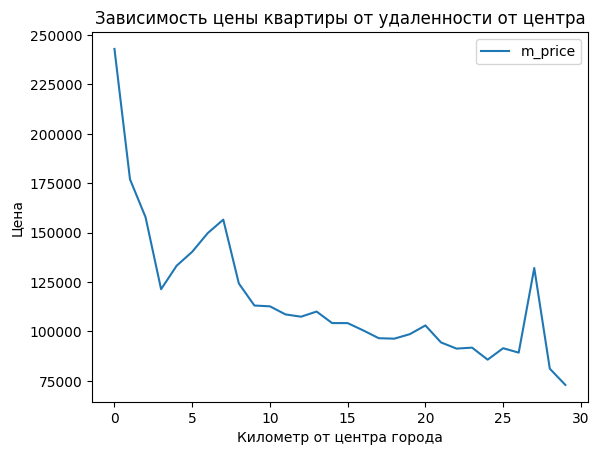

In [21]:
flat_spb = df.query('locality_name == "санкт-петербург"') #выбираем только квартиры в спб
flat_spb.pivot_table(index = 'cityCenters_nearest_km', values = 'm_price').plot()
plt.title('Зависимость цены квартиры от удаленности от центра');
plt.xlabel('Километр от центра города')
plt.ylabel('Цена');

**Выводы по зависимости цены квартиры от ее близости к центру города**
1. Видно, что в целом, чем ближе километр к центру города, тем выше его цена.
2. Однако с 4 км по 7 км цена увеличивается, 7 км по стоимости примерно равен стоимости 2 км.
3. Чем ближе квартира к центру города, тем выше стоимость квартиры. Особенно дорогие квартиры в 8 километрах от центра города.
4. Также цена резко возрастает на 27 км. Его стоимость примерно равна стоимости 4 км.

### Общий вывод
***Характеристики основных параметров в объявлениях, выставляющихся на продажу***
1. Основная масса квартир, выставляющихся на продажу имеет следующие параметры:
 * общую площадь до 200 квадратных метров;
 * жилую площадь до 110 квадратных метров;
 * площадь кухни до 30 квадратных метров;
 * имеет не больше 6 комнат;
 * высота составляет 2-3,5 метра.
2. Квартиры располагаются в основном в домах, в которых в основном не больше 30 этажей, причем больше всего квартир располагается на первых 10 этажах домов.
3. Основная масса квартир продается по цене до 200000 за квадратный метр.
4. Расстояние до ближайшего центра города в основном составляет до 20000 метров (20 км), очень редко оно составляет больше 40 км.
5. В основном расстояние до ближайшего аэропорта состаляет от 10 до 60 км, до ближайшего парка - до 1 км.
6. Чаще всего объявления публикуются во вторник и четверг. Меньше всего объявлений публикуются в выходные.
7. Больше всего объявлений публикуется в периоды с февраля по апрель и с сентября по ноябрь. В остальные месяцы наблюдается спад количества публикаций.

***От чего зависит цена на квартиру***
1. В большей степени цена на квартиру зависит от:
 * общей площади - 0,64;
 * жилой площади - 0,53.
2. В меньшей степени цена на квартиру зависит от:
 * площади кухни - 0,42;
 * количетсва комнат - 0,35.
3. По мере увеличения общей площади, жилой площади, площади кухни и количества комнат цена квадратного метра тоже увеличивается.
4. С остальными параметрами нет четкой взаимосвязи.
5. В 2014 году цены за квадратный метр были самыми низкими. В 2015 году цены выросли, однако дальше существенного роста цен не наблюдалось.
6. Цены за квадратный метр в квартирах, расположенных на первом этаже в целом ниже, чем в квартирах, расположенных на других этажах.

***Выводы по срокам продажи квартир***
1. Большинство квартир продаются в промежуток от 0 до 180 дней с момента публикации объявления.
2. Срок продажи свыше 576 дней можно считать необычно долгим.
3. В основном квартиры продаются быстро, слишком долгих продаж не наблюдается.

***Выводы по ценам на квартиры в 10 самых распространненых населенных пунтках*** 
1. Населенные пункты, с наибольшим числом объявлений по убыванию количества объявлений: 
* санкт-петербург    
* мурино              
* шушары              
* всеволожск          
* пушкин               
* колпино              
* парголово         
* гатчина              
* кудрово             
* выборг               
2. Самая высокая стоимость квадратного метра в Санкт-Петербурге (114850) и Пушкине (1013125).
3. Самая низкая стоимость квадратного метра в Выборге (58141), а также в Гатчине (68746) и Всеволожске (68654).

***Зависимость цены квартиры от ее близости к центру города***
1. В целом, чем ближе километр к центру города, тем выше его цена.
2. Однако с 4 км по 7 км цена увеличивается, 7 км по стоимости примерно равен стоимости 2 км.
3. Чем ближе квартира к центру города, тем выше стоимость квартиры. Особенно дорогие квартиры в 8 километрах от центра города.
4. Также цена резко возрастает на 27 км. Его стоимость примерно равна стоимости 4 км.